In [13]:
import numpy as np
from numpy import linalg as LA
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import functools as ft
from scipy.linalg import block_diag
from sympy import *

In [7]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'

In [8]:
# ===========================================================================================================
# ===================================== Defining few functions for ease ====================================
# ==========================================================================================================

# --------- Conjugate Transpose --------

def conjT(A # Matrix 
         ):
    B = np.conj(A)
    B = np.transpose(B)
    return B

# --- Vector norm and Vector product

def vec_norm(v # column vector
            ):
    norm = conjT(v)@v
    return np.sqrt(norm[0,0])

def vec_prod(u,v # column vectors
            ):
    norm = conjT(u)@v
    return norm[0,0]




-------

**Ordinary Search algorithm**

----

In [16]:
N = 2**1 # lattice sites
pos = np.eye(N) # position space
coin = np.eye(4)  # coin space

In [17]:
# Coin Switch

UD = np.outer(coin[3],coin[0]) # Takes from U to D
DU = np.outer(coin[0],coin[3]) 
LR = np.outer(coin[2],coin[1]) 
RL = np.outer(coin[1],coin[2])  

UU = np.outer(coin[0],coin[0])
DD = np.outer(coin[3],coin[3])
LL = np.outer(coin[1],coin[1])
RR = np.outer(coin[2],coin[2])

In [18]:
# Construction of interior shift Operator 

shift_down = np.kron(np.eye(N),np.diag(np.ones((1,N-1))[0],1))
shift_up = np.kron(np.eye(N),np.diag(np.ones((1,N-1))[0],-1))
shift_left = np.kron(np.diag(np.ones((1,N-1))[0],1),np.eye(N))
shift_right = np.kron(np.diag(np.ones((1,N-1))[0],-1),np.eye(N))

shift_in = np.kron(UD,shift_up) + np.kron(DU,shift_down) + np.kron(LR,shift_left) + np.kron(RL,shift_right)

# Construction of boundary shift operator 

NN = np.zeros((N,N)); NN[N-1,N-1] = 1 
OO = np.zeros((N,N)); OO[0,0] = 1

shift_yN = np.kron(np.eye(N),NN); shift_y0 = np.kron(np.eye(N),OO)
shift_xN = np.kron(NN,np.eye(N)); shift_x0 = np.kron(OO,np.eye(N))

shift_boundary = np.kron(UU,shift_yN) + np.kron(DD,shift_y0) + np.kron(LL,shift_x0) + np.kron(RR,shift_xN)

# Complete shift operator 

shift = shift_in + shift_boundary

In [19]:
print(pd.DataFrame(shift))

     0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
1   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
11  0.0  0.0  0.0  0.0  0.0 

In [29]:
# Grover's Coin Operator 

Qdim = 4
Grover_OP = 2*np.ones((Qdim,Qdim))/Qdim - np.eye(Qdim)

# Evolution operator for the walk

Evolution_OP = shift@np.kron(Grover_OP,np.eye(N**2))

# Oracle -  

# list_ = [[2,2],[N-2,N-2],[2,N-2],[N-2,2]] # [[np.random.randint(0,N-1),np.random.randint(0,N-1)],[np.random.randint(0,N-1),np.random.randint(0,N-1)]]
list_ = [[6, 8] , [8, 9], [12, 5], [15, 5]]

def ORACLE(marked_points):
    # basis = []
    ϕm = np.linspace(0,np.pi/10,len(marked_points))
    mm = np.zeros((N**2,N**2))
    for i in range(len(marked_points)):
        θm = ϕm[i]
        # θm =  # np.random.uniform(0,np.pi)
        xx = np.zeros((N,1)); yy = np.zeros((N,1))
        coordinate = marked_points[i]
        xx[coordinate[0],0] = 1; yy[coordinate[1],0] = 1
        basis = np.kron(xx,yy)
        mm = mm + (np.cos(θm)*np.exp(1j*θm))*basis@conjT(basis)
    
    R = np.eye(Qdim*N**2) - np.kron((2*np.ones((Qdim,Qdim))/Qdim),mm)
    
    return R

oracle = ORACLE(list_)

In [35]:
U = Evolution_OP@oracle 

# Initial State -----

Ψ0 = np.ones((Qdim*N**2,1))
Ψ0 = Ψ0/vec_norm(Ψ0)


# Evolution ------

Ψt = np.copy(Ψ0)
steps = 60
prob = np.zeros((steps,len(list_)))

xx = np.zeros((N,1)); yy = np.zeros((N,1))


for i in range(steps):
    for j in range(len(list_)):
        xx = np.zeros((N,1)); yy = np.zeros((N,1))
        coordinate = list_[j]
        xx[coordinate[0],0] = 1; yy[coordinate[1],0] = 1
        basis = np.kron(xx,yy)
        ϕ1 = np.kron(coin[:,[0]],basis); ϕ2 = np.kron(coin[:,[1]],basis); ϕ3 = np.kron(coin[:,[2]],basis); ϕ4 = np.kron(coin[:,[3]],basis)
        
        prob[i,j] = np.absolute(conjT(ϕ1)@Ψt)**2 + np.absolute(conjT(ϕ2)@Ψt)**2 + np.absolute(conjT(ϕ3)@Ψt)**2 + np.absolute(conjT(ϕ4)@Ψt)**2 
    
    Ψt = U@Ψt


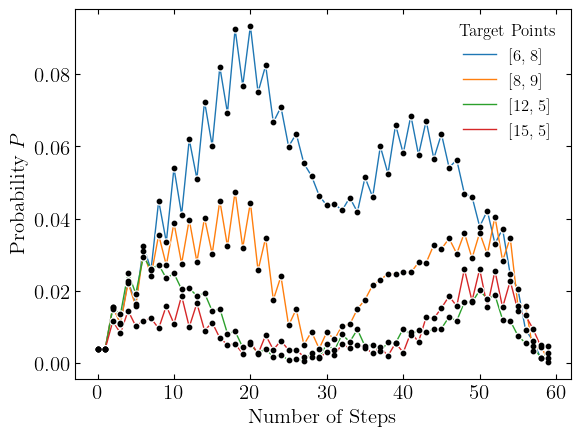

In [55]:
xaxis = np.linspace(0,steps-1,steps)
# mpl.rcParams['axes.spines.right'] = True
# mpl.rcParams['axes.spines.top'] = True
# mpl.rcParams['font.family'] = 'Calibri'


ax = plt.subplot(111)

for i in range(len(list_)):
    ax.scatter(xaxis, prob[:,i], color='white', s=25, zorder=2)
    ax.scatter(xaxis, prob[:,i], color='black', s=10, zorder=3)
    ax.plot(xaxis,prob[:,i], linestyle='-', linewidth=1, zorder=1,label = str(list_[i]))
    
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='both', labelsize=15)
font2 = {'family':'serif','color':'black','size':15}
plt.xlabel('Number of Steps',fontdict = font2)
plt.ylabel('Probability $P$',fontdict = font2)
plt.legend(title = 'Target Points',loc='best', frameon = False,fontsize = 12,title_fontsize = 12)
plt.show()

-------

In [11]:
# Constructing Shift Operator -- Periodic boundary condition 

shift_down = np.kron(np.eye(N),np.roll(np.eye(N), 1, axis=0))
shift_up = np.kron(np.eye(N),np.roll(np.eye(N), -1, axis=0))
shift_left = np.kron(np.roll(np.eye(N), 1, axis=0),np.eye(N))
shift_right = np.kron(np.roll(np.eye(N), -1, axis=0),np.eye(N))

shift = np.kron(UD,shift_up) + np.kron(DU,shift_down) + np.kron(LR,shift_left) + np.kron(RL,shift_right)

In [15]:
Matrix(shift)

Matrix([
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0,   0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0,   0,   0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0,   0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0,   0,   0, 1.0,   0,   0,   0,   0,   0,   0,   0,   0],
[  0,   0,   0,   0, 1.0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
[  0, 1

In [59]:
# Grover's Coin Operator 

Qdim = 4
Grover_OP = 2*np.ones((Qdim,Qdim))/Qdim - np.eye(Qdim)

# Evolution operator for the walk

Evolution_OP = shift@np.kron(Grover_OP,np.eye(N**2))

# Oracle -  

# list_ = [[2,2],[N-2,N-2],[2,N-2],[N-2,2]] # [[np.random.randint(0,N-1),np.random.randint(0,N-1)],[np.random.randint(0,N-1),np.random.randint(0,N-1)]]

# linear-set of points 
list_ =  [[6, 8] , [8, 9], [12, 5], [15, 5]] # [[2,2],[2,4]] # ,[2,6],[2,8]]

ϕm = [np.pi*(m)/(N) for m in range(len(list_))] # np.zeros(len(list_)) # np.linspace(0,np.pi/10,len(marked_points))
# ϕm = np.zeros(len(list_))

def ORACLE(marked_points,ϕm):
    # basis = []
    mm = np.zeros((N**2,N**2))
    for i in range(len(marked_points)):
        θm = ϕm[i]
        # θm =  # np.random.uniform(0,np.pi)
        xx = np.zeros((N,1)); yy = np.zeros((N,1))
        coordinate = marked_points[i]
        xx[coordinate[0],0] = 1; yy[coordinate[1],0] = 1
        basis = np.kron(xx,yy)
        mm = mm + (np.cos(θm)*np.exp(1j*θm))*basis@conjT(basis)
    
    R = np.eye(Qdim*N**2) - np.kron((2*np.ones((Qdim,Qdim))/Qdim),mm)
    return R

oracle = ORACLE(list_,ϕm)

In [60]:
U = Evolution_OP@oracle 

# Initial State -----

Ψ0 = np.ones((Qdim*N**2,1))
Ψ0 = Ψ0/vec_norm(Ψ0)


# Evolution ------

Ψt = np.copy(Ψ0)
steps = 50
prob = np.zeros((steps,len(list_)))

xx = np.zeros((N,1)); yy = np.zeros((N,1))


for i in range(steps):
    for j in range(len(list_)):
        xx = np.zeros((N,1)); yy = np.zeros((N,1))
        coordinate = list_[j]
        xx[coordinate[0],0] = 1; yy[coordinate[1],0] = 1
        basis = np.kron(xx,yy)
        ϕ1 = np.kron(coin[:,[0]],basis); ϕ2 = np.kron(coin[:,[1]],basis); ϕ3 = np.kron(coin[:,[2]],basis); ϕ4 = np.kron(coin[:,[3]],basis)
        
        prob[i,j] = np.absolute(conjT(ϕ1)@Ψt)**2 + np.absolute(conjT(ϕ2)@Ψt)**2 + np.absolute(conjT(ϕ3)@Ψt)**2 + np.absolute(conjT(ϕ4)@Ψt)**2 
    
    Ψt = U@Ψt

                


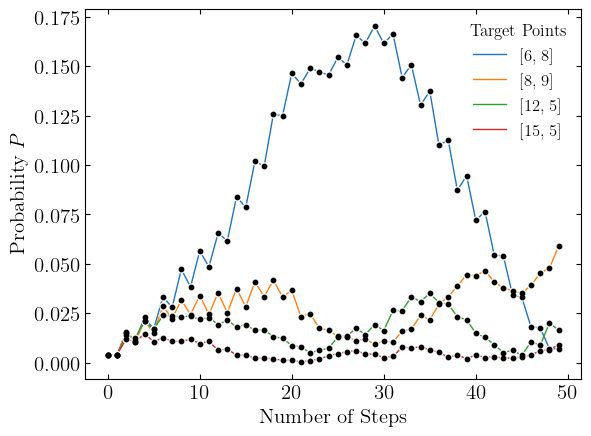

In [62]:
xaxis = np.linspace(0,steps-1,steps)
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['font.family'] = 'Calibri'


ax = plt.subplot(111)

for i in range(len(list_)):
    ax.scatter(xaxis, prob[:,i], color='white', s=25, zorder=2)
    ax.scatter(xaxis, prob[:,i], color='black', s=10, zorder=3)
    ax.plot(xaxis,prob[:,i], linestyle='-', linewidth=1, zorder=1,label = str(list_[i]))
    
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='both', labelsize=15)
font2 = {'family':'serif','color':'black','size':15}
plt.xlabel('Number of Steps',fontdict = font2)
plt.ylabel('Probability $P$',fontdict = font2)
plt.legend(title = 'Target Points',loc='best', frameon = False,fontsize = 12,title_fontsize = 12)
plt.show()

#### 
----------------
**Single Layer Amplification**

--------

-----------

Periodic Boundary Condition

---------

In [63]:
N = 2**4 # lattice sites
pos = np.eye(N) # position space
coin = np.eye(4)  # coin space

In [88]:
# Coin Switch

UD = np.outer(coin[3],coin[0]) # Takes from U to D
DU = np.outer(coin[0],coin[3]) 
LR = np.outer(coin[2],coin[1]) 
RL = np.outer(coin[1],coin[2])  

UU = np.outer(coin[0],coin[0])
DD = np.outer(coin[3],coin[3])
LL = np.outer(coin[1],coin[1])
RR = np.outer(coin[2],coin[2])

In [89]:
# Constructing Shift Operator -- Periodic boundary condition 

shift_down = np.kron(np.eye(N),np.roll(np.eye(N), 1, axis=0))
shift_up = np.kron(np.eye(N),np.roll(np.eye(N), -1, axis=0))
shift_left = np.kron(np.roll(np.eye(N), 1, axis=0),np.eye(N))
shift_right = np.kron(np.roll(np.eye(N), -1, axis=0),np.eye(N))

shift = np.kron(UD,shift_up) + np.kron(DU,shift_down) + np.kron(LR,shift_left) + np.kron(RL,shift_right)

In [90]:
print('Is shift operator unitary?', np.allclose(shift@conjT(shift),np.eye(N**2*4)))

Is shift operator unitary? True


In [91]:
# Grover's Coin Operator 

Qdim = 4
Grover_OP = 2*np.ones((Qdim,Qdim))/Qdim - np.eye(Qdim)

# Evolution operator for the walk

Evolution_OP = shift@np.kron(Grover_OP,np.eye(N**2))


list_ = [[[6, 8]], [[8, 9]], [[12, 5]], [[15, 5]]] # [[[np.random.randint(0,N),np.random.randint(0,N)]] for i in range(4)]   # [[[1,1],[2,2]],[[4,1]],[[3,2]]] # [[2,2],[2,4]] # ,[2,6],[2,8]]


def ORACLE(marked_points):
    # basis = []
    mm = np.zeros((N**2,N**2))
    for i in range(len(marked_points)):
        θm = 0 # ϕm[i]
        # θm =  # np.random.uniform(0,np.pi)
        xx = np.zeros((N,1)); yy = np.zeros((N,1))
        coordinate = marked_points[i]
        xx[coordinate[0],0] = 1; yy[coordinate[1],0] = 1
        basis = np.kron(xx,yy)
        mm = mm + basis@conjT(basis)
    
    R = np.eye(Qdim*N**2) - np.kron((2*np.ones((Qdim,Qdim))/Qdim),mm)
    return R



In [92]:
oracle_list = []
evolution_op_list = []

for i in range(len(list_)):
    oracle_list.append(ORACLE(list_[i]))
    evolution_op_list.append(Evolution_OP)


oracle = ft.reduce(block_diag,oracle_list)
evolution_op = ft.reduce(block_diag,evolution_op_list)

In [93]:
np.allclose(oracle_list[0]@conjT(oracle_list[0]),np.eye(Qdim*N**2))

True

In [94]:
U = evolution_op@oracle 

# Initial State -----

layers = len(list_)
Ψ0 = np.ones((Qdim*N**2*layers,1))
Ψ0 = Ψ0/vec_norm(Ψ0)


# Evolution ------

Ψt = np.copy(Ψ0)
steps = 50
P = []

for i in range(steps):
    Pt = []
    for k in range(layers):
        ψt = Ψt[k*Qdim*N**2:k*Qdim*N**2 + Qdim*N**2]
        P_layer = np.zeros((N,N))
        for xx in range(N):
            xket = np.zeros((N,1))
            xket[xx,0] = 1
            for yy in range(N):
                yket = np.zeros((N,1))
                yket[yy,0] = 1
                basis = np.kron(xket,yket)
                pt = 0
                for ii in range(4):
                    ϕ = np.kron(coin[:,[ii]],basis)
                    pt = pt + np.absolute(conjT(ϕ)@ψt)**2
                P_layer[xx,yy] = pt
        Pt.append(P_layer)
    P.append(Pt)
    Ψt = U@Ψt


In [95]:
U = evolution_op@oracle 

# Initial State -----


layers = len(list_)
Ψ0 = np.ones((Qdim*N**2*layers,1))
Ψ0 = Ψ0/vec_norm(Ψ0)


# Evolution ------

Ψt = np.copy(Ψ0)
steps = 50
prob = [np.zeros((steps,len(list_[i]))) for i in range(layers)] # np.zeros((steps,layers))

for i in range(steps):    
    for k in range(layers):
        ψt = Ψt[k*Qdim*N**2:k*Qdim*N**2 + Qdim*N**2]
        list__ = list_[k]
        tot_marked = len(list__)
        for j in range(tot_marked):
            xx = np.zeros((N,1)); yy = np.zeros((N,1))
            coordinate = list__[j]
            xx[coordinate[0],0] = 1; yy[coordinate[1],0] = 1
            basis = np.kron(xx,yy)
            ϕ1 = np.kron(coin[:,[0]],basis); ϕ2 = np.kron(coin[:,[1]],basis); ϕ3 = np.kron(coin[:,[2]],basis); ϕ4 = np.kron(coin[:,[3]],basis)

            prob[k][i,j] = np.absolute(conjT(ϕ1)@ψt)**2 + np.absolute(conjT(ϕ2)@ψt)**2 + np.absolute(conjT(ϕ3)@ψt)**2 + np.absolute(conjT(ϕ4)@ψt)**2 
    Ψt = U@Ψt



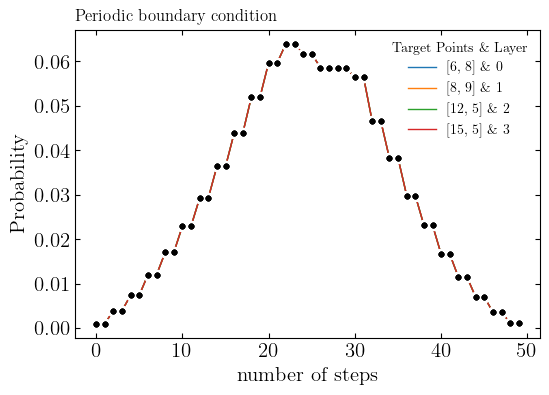

In [98]:
xaxis = np.linspace(0,steps-1,steps)

fig, ax = plt.subplots(figsize = (6,4))

for j in range(layers):
    p = prob[j]
    list__ = list_[j]
    tot_marked = len(list__)
    for i in range(tot_marked):
        ax.scatter(xaxis, p[:,i], color='white', s=50, zorder=2)
        ax.scatter(xaxis, p[:,i], color='black', s=10, zorder=3)
        ax.plot(xaxis,p[:,i], linestyle='-', linewidth=1, zorder=1,label = str(list__[i]) +' \& ' + str(j))

font2 = {'family':'serif','color':'black','size':15}
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='both', labelsize=15)
plt.legend(title = r'Target Points \& Layer',loc='best', frameon = False)
# plt.xlim(0,20)
plt.xlabel(r'number of steps',fontdict = font2)
plt.ylabel(r'Probability',fontdict = font2)
plt.title('Periodic boundary condition',loc='left')
fig = 'PLOTS/Search_On_Torus_' + str(np.round(np.random.uniform(),3)) + '.jpg'
# plt.savefig(fig, dpi= 500 , bbox_inches = 'tight')
plt.savefig('single_layer_PBC.pdf',dpi = 500, bbox_inches='tight')
plt.show()


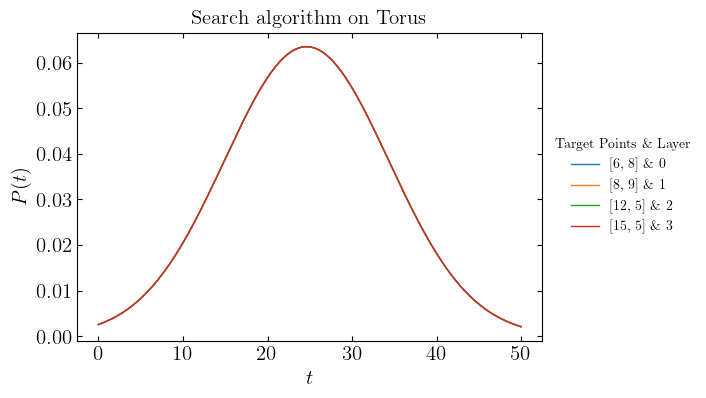

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define the Gaussian function
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-((x - mean) / std_dev)**2 / 2)

# Generate sample data
x = np.linspace(0,steps-1,steps)
fig, ax = plt.subplots(figsize = (6,4))

for j in range(layers):
    p = prob[j]
    list__ = list_[j]
    tot_marked = len(list__)
    for i in range(tot_marked):
        x = np.linspace(0,steps-1,steps)
        y = p[:,i]
        initial_guess = [1.0, 0.0, 1.0]  # Initial guess for amplitude, mean, and std_dev
        params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)
        fitted_amplitude, fitted_mean, fitted_std_dev = params
        x = np.linspace(0,steps,4*steps)
        ax.plot(x, gaussian(x, fitted_amplitude, fitted_mean, fitted_std_dev),linestyle='-', linewidth=1, zorder=1,label = str(list__[i]) +' \& ' + str(j))
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='major', labelsize=15)
font2 = {'family':'serif','color':'black','size':15}
plt.xlabel(r'$t$',fontdict = font2)
plt.ylabel(r'$P(t)$',fontdict = font2)
plt.legend(title = r'Target Points \& Layer',loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)

plt.title('Search algorithm on Torus',fontdict = font2)
fig = 'PLOTS/Search_On_Torus_' + str(np.round(np.random.uniform(),3)) + '.jpg'
# plt.savefig(fig, dpi= 500 , bbox_inches = 'tight')
plt.show()


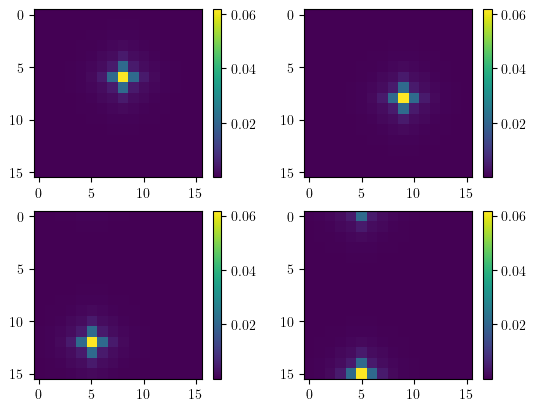

In [100]:
mx = int(fitted_mean)
fig, axs = plt.subplots(2, 2)

ii = 0
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        pcm = ax.imshow(P[mx][ii])
        fig.colorbar(pcm, ax=ax)
        ii +=1


plt.show()

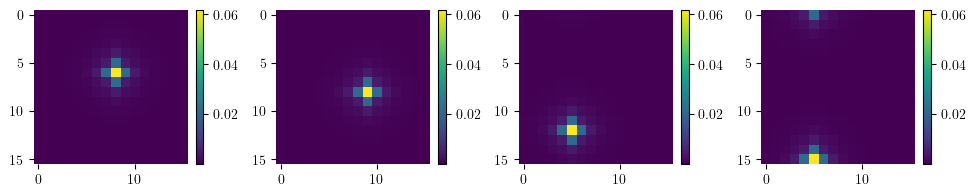

In [110]:
fig, axs = plt.subplots(1, 4,figsize = (12,2))

for i in range(4):
    ax = axs[i]
    pcm = ax.imshow(P[mx][i],cmap = 'viridis')
    fig.colorbar(pcm, ax=ax,fraction=0.046, pad=0.04)
    plt.setp(ax.spines.values(), alpha = 0)
    # ax.tick_params(which = 'both', size = 0, labelsize = 0,color = 'w')
plt.savefig('single_layer_PBC_MAT.pdf',dpi = 500, bbox_inches='tight')
plt.show()

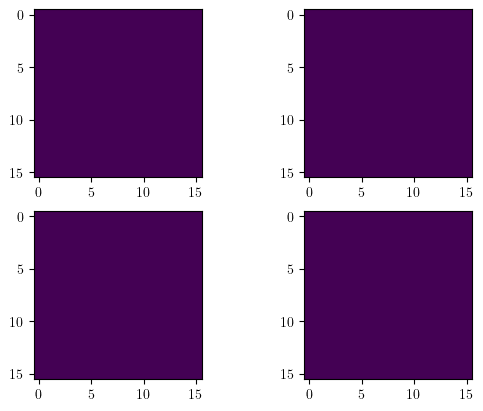

MovieWriter ffmpeg unavailable; using Pillow instead.


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, axs = plt.subplots(2, 2)



# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(steps):
    # im = ax.imshow(P[i][0], animated=True)
    ii = 0
    for k in range(2):
        for j in range(2):
            ax = axs[k, j]
            im = ax.imshow(P[i][ii],animated = True)
            # fig.colorbar(im, ax=ax)
            # print(ii)
            ii +=1
    
    if i == 0:
        # ax.imshow(P[0][0])  # show an initial one first
        ii = 0
        for k in range(2):
            for j in range(2):
                ax = axs[k, j]
                im = ax.imshow(P[0][ii])
                # fig.colorbar(im, ax=ax)
                ii+=1
    ims.append([im])
# cbar = plt.colorbar(im)
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
ani.save('filename.gif')
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

------------

Open Boundary Condition

--------

In [111]:
# Construction of interior shift Operator 

shift_down = np.kron(np.eye(N),np.diag(np.ones((1,N-1))[0],1))
shift_up = np.kron(np.eye(N),np.diag(np.ones((1,N-1))[0],-1))
shift_left = np.kron(np.diag(np.ones((1,N-1))[0],1),np.eye(N))
shift_right = np.kron(np.diag(np.ones((1,N-1))[0],-1),np.eye(N))

shift_in = np.kron(UD,shift_up) + np.kron(DU,shift_down) + np.kron(LR,shift_left) + np.kron(RL,shift_right)

# Construction of boundary shift operator 

NN = np.zeros((N,N)); NN[N-1,N-1] = 1 
OO = np.zeros((N,N)); OO[0,0] = 1

shift_yN = np.kron(np.eye(N),NN); shift_y0 = np.kron(np.eye(N),OO)
shift_xN = np.kron(NN,np.eye(N)); shift_x0 = np.kron(OO,np.eye(N))

shift_boundary = np.kron(UU,shift_yN) + np.kron(DD,shift_y0) + np.kron(LL,shift_x0) + np.kron(RR,shift_xN)

# Complete shift operator 

shift = shift_in + shift_boundary

In [112]:
print('Is shift operator unitary?', np.allclose(shift@conjT(shift),np.eye(N**2*4)))

Is shift operator unitary? True


In [113]:
# Grover's Coin Operator 

Qdim = 4
Grover_OP = 2*np.ones((Qdim,Qdim))/Qdim - np.eye(Qdim)

# Evolution operator for the walk

Evolution_OP = shift@np.kron(Grover_OP,np.eye(N**2))


list_ = [[[6, 8]], [[8, 9]], [[12, 5]], [[15, 5]]] # [[[np.random.randint(0,N),np.random.randint(0,N)]] for i in range(4)]   # [[[1,1],[2,2]],[[4,1]],[[3,2]]] # [[2,2],[2,4]] # ,[2,6],[2,8]]


def ORACLE(marked_points):
    # basis = []
    mm = np.zeros((N**2,N**2))
    for i in range(len(marked_points)):
        θm = 0 # ϕm[i]
        # θm =  # np.random.uniform(0,np.pi)
        xx = np.zeros((N,1)); yy = np.zeros((N,1))
        coordinate = marked_points[i]
        xx[coordinate[0],0] = 1; yy[coordinate[1],0] = 1
        basis = np.kron(xx,yy)
        mm = mm + basis@conjT(basis)
    
    R = np.eye(Qdim*N**2) - np.kron((2*np.ones((Qdim,Qdim))/Qdim),mm)
    return R



In [114]:
oracle_list = []
evolution_op_list = []

for i in range(len(list_)):
    oracle_list.append(ORACLE(list_[i]))
    evolution_op_list.append(Evolution_OP)


oracle = ft.reduce(block_diag,oracle_list)
evolution_op = ft.reduce(block_diag,evolution_op_list)

In [115]:
np.allclose(oracle_list[0]@conjT(oracle_list[0]),np.eye(Qdim*N**2))

True

In [116]:
U = evolution_op@oracle 

# Initial State -----

layers = len(list_)
Ψ0 = np.ones((Qdim*N**2*layers,1))
Ψ0 = Ψ0/vec_norm(Ψ0)


# Evolution ------

Ψt = np.copy(Ψ0)
steps = 50
P = []

for i in range(steps):
    Pt = []
    for k in range(layers):
        ψt = Ψt[k*Qdim*N**2:k*Qdim*N**2 + Qdim*N**2]
        P_layer = np.zeros((N,N))
        for xx in range(N):
            xket = np.zeros((N,1))
            xket[xx,0] = 1
            for yy in range(N):
                yket = np.zeros((N,1))
                yket[yy,0] = 1
                basis = np.kron(xket,yket)
                pt = 0
                for ii in range(4):
                    ϕ = np.kron(coin[:,[ii]],basis)
                    pt = pt + np.absolute(conjT(ϕ)@ψt)**2
                P_layer[xx,yy] = pt
        Pt.append(P_layer)
    P.append(Pt)
    Ψt = U@Ψt


In [117]:
U = evolution_op@oracle 

# Initial State -----


layers = len(list_)
Ψ0 = np.ones((Qdim*N**2*layers,1))
Ψ0 = Ψ0/vec_norm(Ψ0)


# Evolution ------

Ψt = np.copy(Ψ0)
steps = 80
prob = [np.zeros((steps,len(list_[i]))) for i in range(layers)] # np.zeros((steps,layers))

for i in range(steps):    
    for k in range(layers):
        ψt = Ψt[k*Qdim*N**2:k*Qdim*N**2 + Qdim*N**2]
        list__ = list_[k]
        tot_marked = len(list__)
        for j in range(tot_marked):
            xx = np.zeros((N,1)); yy = np.zeros((N,1))
            coordinate = list__[j]
            xx[coordinate[0],0] = 1; yy[coordinate[1],0] = 1
            basis = np.kron(xx,yy)
            ϕ1 = np.kron(coin[:,[0]],basis); ϕ2 = np.kron(coin[:,[1]],basis); ϕ3 = np.kron(coin[:,[2]],basis); ϕ4 = np.kron(coin[:,[3]],basis)

            prob[k][i,j] = np.absolute(conjT(ϕ1)@ψt)**2 + np.absolute(conjT(ϕ2)@ψt)**2 + np.absolute(conjT(ϕ3)@ψt)**2 + np.absolute(conjT(ϕ4)@ψt)**2 
    Ψt = U@Ψt



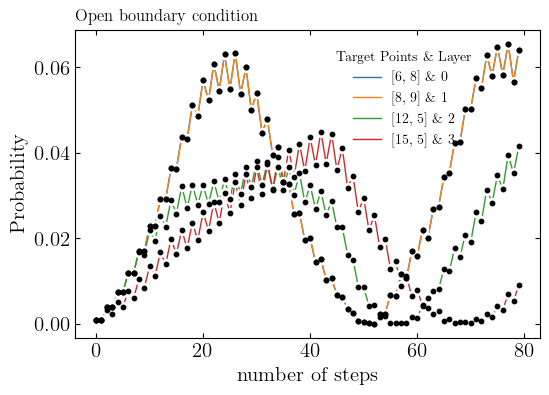

In [153]:
xaxis = np.linspace(0,steps-1,steps)

fig, ax = plt.subplots(figsize = (6,4))
mx = []
for j in range(layers):
    p = prob[j]
    list__ = list_[j]
    tot_marked = len(list__)
    for i in range(tot_marked):
        ax.scatter(xaxis, p[:,i], color='white', s=50, zorder=2)
        ax.scatter(xaxis, p[:,i], color='black', s=10, zorder=3)
        ax.plot(xaxis,p[:,i], linestyle='-', linewidth=1, zorder=1,label = str(list__[i]) +' \& ' + str(j))
    mx.append(np.argmax(p[0:50,i]))
        
font2 = {'family':'serif','color':'black','size':15}
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='both', labelsize=15)
plt.legend(title = r'Target Points \& Layer',loc=(0.55,0.6),frameon = False) #,bbox_to_anchor=(1,0.5))
plt.xlabel(r'number of steps',fontdict = font2)
plt.ylabel(r'Probability',fontdict = font2)
plt.title('Open boundary condition',loc='left')
# plt.savefig('single_layer_OBC.pdf',dpi = 500, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define the Gaussian function
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-((x - mean) / std_dev)**2 / 2)

# Generate sample data
x = np.linspace(0,steps-1,steps)
fig, ax = plt.subplots(figsize = (6,4))

for j in range(layers):
    p = prob[j]
    list__ = list_[j]
    tot_marked = len(list__)
    for i in range(tot_marked):
        x = np.linspace(0,steps-1,steps)
        y = p[:,i]
        initial_guess = [1.0, 0.0, 1.0]  # Initial guess for amplitude, mean, and std_dev
        params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)
        fitted_amplitude, fitted_mean, fitted_std_dev = params
        x = np.linspace(0,steps,4*steps)
        ax.plot(x, gaussian(x, fitted_amplitude, fitted_mean, fitted_std_dev),linestyle='-', linewidth=1, zorder=1,label = str(list__[i]) +' \& ' + str(j))
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='major', labelsize=15)
font2 = {'family':'serif','color':'black','size':15}
plt.xlabel(r'$t$',fontdict = font2)
plt.ylabel(r'$P(t)$',fontdict = font2)
plt.legend(title = r'Target Points \& Layer',loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)

plt.title('Search algorithm on Torus',fontdict = font2)
fig = 'PLOTS/Search_On_Torus_' + str(np.round(np.random.uniform(),3)) + '.jpg'
# plt.savefig(fig, dpi= 500 , bbox_inches = 'tight')
plt.show()


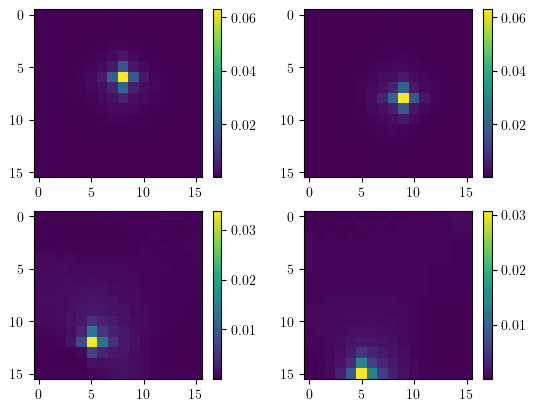

In [69]:
mx = int(fitted_mean)
fig, axs = plt.subplots(2, 2)

ii = 0
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        pcm = ax.imshow(P[mx][ii])
        fig.colorbar(pcm, ax=ax)
        ii +=1


plt.show()

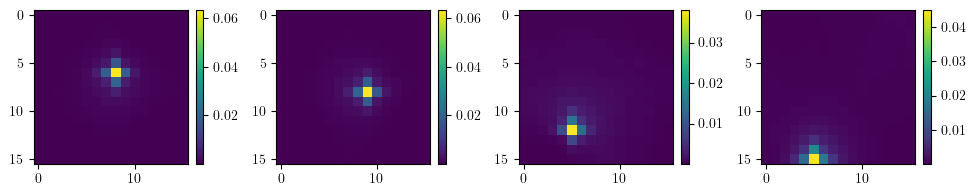

In [155]:

fig, axs = plt.subplots(1, 4,figsize = (12,2))

for i in range(4):
    ax = axs[i]
    pcm = ax.imshow(P[mx[i]][i])
    fig.colorbar(pcm, ax=ax,fraction=0.046, pad=0.04)
plt.savefig('single_layer_OBC_MAT.pdf',dpi = 500, bbox_inches='tight')
plt.show()

#### 
----------------
**Multilayer Layer Amplification**

--------

------

Periodic Boundary Condition

--------

In [4]:
_0 = np.array([[1],[0]]); _1 = np.array([[0],[1]])

_00 = _0@conjT(_0)
_01 = _0@conjT(_1)
_10 = _1@conjT(_0)
_11 = _1@conjT(_1)


In [5]:
# Define labels :

list_ = [[[6, 8]], [[8, 9]], [[12, 5]], [[15, 5]]]

In [6]:
N = 2**4 # lattice sites
n = len(list_) # number of layers

TPlus = np.roll(np.eye(N), 1, axis=0)
TMinus = np.roll(np.eye(N), -1, axis=0)
I = np.eye(N)

tplus = np.roll(np.eye(n), 1, axis=0)
tminus = np.roll(np.eye(n), -1, axis=0)
iden = np.eye(n)

In [7]:
# Constructing shift operator :

S = np.kron(ft.reduce(np.kron,[_10,_10,_10]), ft.reduce(np.kron,[I,TPlus,tplus])) + np.kron(ft.reduce(np.kron,[_10,_01,_10]), ft.reduce(np.kron,[TPlus,I,tplus])) + np.kron(ft.reduce(np.kron,[_10,_10,_01]), ft.reduce(np.kron,[I,TPlus,tminus])) + np.kron(ft.reduce(np.kron,[_10,_01,_01]), ft.reduce(np.kron,[TPlus,I,tminus])) + np.kron(ft.reduce(np.kron,[_01,_10,_10]), ft.reduce(np.kron,[TMinus,I,tplus])) + np.kron(ft.reduce(np.kron,[_01,_10,_01]), ft.reduce(np.kron,[TMinus,I,tminus])) + np.kron(ft.reduce(np.kron,[_01,_01,_10]), ft.reduce(np.kron,[I,TMinus,tplus])) + np.kron(ft.reduce(np.kron,[_01,_01,_01]), ft.reduce(np.kron,[I,TMinus,tminus])) 

In [8]:
# Is this unitary? :

print('Is shift operator unitary?' , np.allclose(S@conjT(S),np.eye(N**2*n*8)) )


Is shift operator unitary? True


In [9]:
def grover_coin_operator(n):
    N = 2 ** n
    H = np.ones((N, N)) / N  # Hadamard matrix (normalized)

    # Construct the Grover's coin operator
    coin_operator = 2 * H - np.identity(N)

    return coin_operator


In [10]:
# Grover's Coin Operator 

Qdim = 2**3
Sdim = N*N*n
dim = Qdim*Sdim

Grover_OP = grover_coin_operator(3) # 2*np.ones((Qdim,Qdim))/Qdim - np.eye(Qdim)

G = np.kron(Grover_OP,np.eye(Sdim))

# Evolution Operator : 

EVOLUTION = S@G


In [11]:
# Oracle -  
Ψc = np.ones((Qdim,1))
Ψc = Ψc/vec_norm(Ψc)

ΨcΨc = Ψc@conjT(Ψc)

mm = np.zeros((Sdim,Sdim))

for i in range(n):
    xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))
    coordinate = list_[i]
    for j in range(len(coordinate)):
        marked_point = coordinate[j]
        xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))
        xx[marked_point[0],0] = 1; yy[marked_point[1],0] = 1; zz[i,0] = 1
        basis = ft.reduce(np.kron,[xx,yy,zz]) # np.kron(xx,yy)
        mm = mm + basis@conjT(basis)

R = np.eye(dim) - 2*np.kron(ΨcΨc,mm) # np.kron((2*np.ones((Qdim,Qdim))/Qdim),mm)


In [12]:
# Total evolution operator :

U = EVOLUTION@R


In [14]:
from tqdm import tqdm

In [15]:
# Initial State -----

Ψ0 = np.ones((dim,1))
Ψ0 = Ψ0/vec_norm(Ψ0)
coin = np.eye(Qdim)

# Evolution ------

Ψt = np.copy(Ψ0)
steps = 50
prob = [np.zeros((steps,len(list_[i]))) for i in range(n)] # np.zeros((steps,layers))

xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))

for i in tqdm(range(steps)):
    for k in range(n):
        coordinate = list_[k]
        for j in range(len(coordinate)):
            marked_point = coordinate[j]
            xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))
            xx[marked_point[0],0] = 1; yy[marked_point[1],0] = 1; zz[k,0] = 1
            basis = ft.reduce(np.kron,[xx,yy,zz])
            for ii in range(Qdim):
                ϕ = np.kron(coin[:,[ii]],basis)
                prob[k][i,j] = prob[k][i,j] + np.absolute(conjT(ϕ)@Ψt)**2
        
    Ψt = U@Ψt


100%|██████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.58it/s]


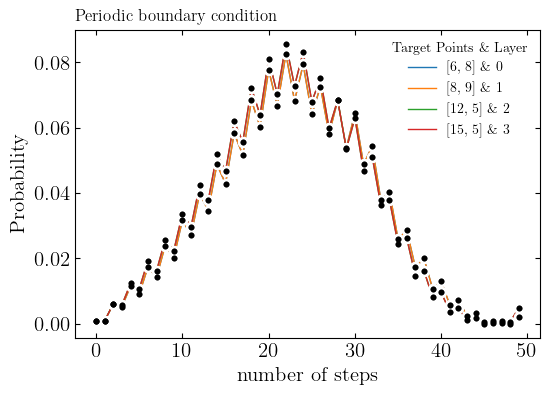

In [22]:
xaxis = np.linspace(0,steps-1,steps)

fig, ax = plt.subplots(figsize = (6,4))
layers = len(list_)
for j in range(layers):
    p = prob[j]
    list__ = list_[j]
    tot_marked = len(list__)
    for i in range(tot_marked):
        ax.scatter(xaxis, p[:,i], color='white', s=50, zorder=2)
        ax.scatter(xaxis, p[:,i], color='black', s=10, zorder=3)
        ax.plot(xaxis,p[:,i], linestyle='-', linewidth=1, zorder=1,label = str(list__[i]) +' \& ' + str(j))

font2 = {'family':'serif','color':'black','size':15}
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='both', labelsize=15)
plt.legend(title = r'Target Points \& Layer',loc='best',frameon = False)
plt.xlabel(r'number of steps',fontdict = font2)
plt.ylabel(r'Probability',fontdict = font2)
plt.title('Periodic boundary condition',loc='left')
plt.savefig('multi_layer_PBC.pdf',dpi = 500, bbox_inches='tight')
plt.show()

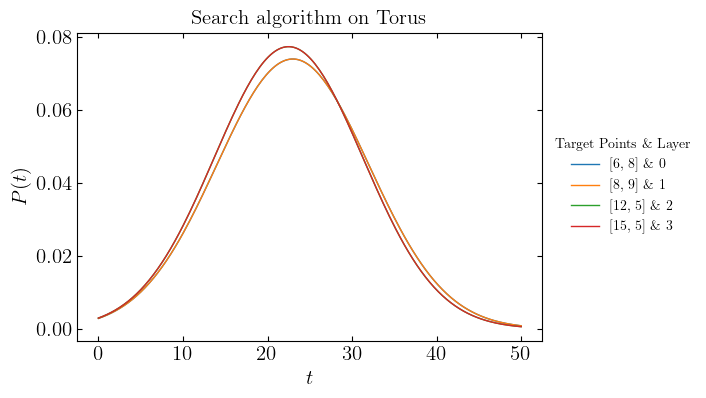

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define the Gaussian function
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-((x - mean) / std_dev)**2 / 2)
mx = []
# Generate sample data
x = np.linspace(0,steps-1,steps)
fig, ax = plt.subplots(figsize = (6,4))

for j in range(layers):
    p = prob[j]
    list__ = list_[j]
    tot_marked = len(list__)
    for i in range(tot_marked):
        x = np.linspace(0,steps-1,steps)
        y = p[:,i]
        initial_guess = [1.0, 0.0, 1.0]  # Initial guess for amplitude, mean, and std_dev
        params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)
        fitted_amplitude, fitted_mean, fitted_std_dev = params
        x = np.linspace(0,steps,4*steps)
        ax.plot(x, gaussian(x, fitted_amplitude, fitted_mean, fitted_std_dev),linestyle='-', linewidth=1, zorder=1,label = str(list__[i]) +' \& ' + str(j))
    mx.append(int(fitted_mean))
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='major', labelsize=15)
font2 = {'family':'serif','color':'black','size':15}
plt.xlabel(r'$t$',fontdict = font2)
plt.ylabel(r'$P(t)$',fontdict = font2)
plt.legend(title = r'Target Points \& Layer',loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)

plt.title('Search algorithm on Torus',fontdict = font2)
fig = 'PLOTS/Search_On_Torus_' + str(np.round(np.random.uniform(),3)) + '.jpg'
# plt.savefig(fig, dpi= 500 , bbox_inches = 'tight')
plt.show()


In [23]:
# Initial State -----

Ψ0 = np.ones((dim,1))
Ψ0 = Ψ0/vec_norm(Ψ0)
coin = np.eye(Qdim)

# Evolution ------

Ψt = np.copy(Ψ0)
steps = 50
P = []

for i in range(steps):
    Pt = np.zeros((N,N,n),dtype = float)
    for kk in range(n):
        zz = np.zeros((n,1))
        zz[kk,0] = 1
        for ii in range(N):
            xx = np.zeros((N,1))
            xx[ii,0] = 1
            for jj in range(N):
                yy = np.zeros((N,1))
                yy[jj,0] = 1
                basis = ft.reduce(np.kron,[xx,yy,zz])
                for cc in range(Qdim):
                    ϕ = np.kron(coin[:,[cc]],basis)
                    Pt[ii,jj,kk] = Pt[ii,jj,kk] + np.absolute(conjT(ϕ)@Ψt)**2
    P.append(Pt)
    Ψt = U@Ψt


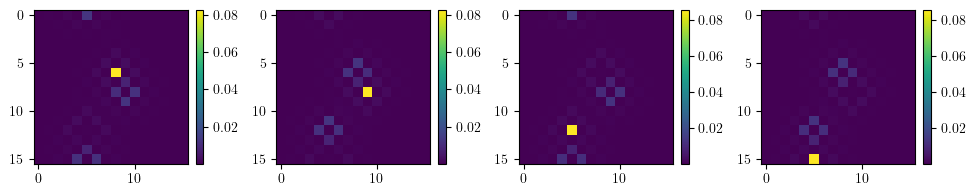

In [26]:
fig, axs = plt.subplots(1, 4,figsize = (12,2))


for i in range(4):
    ax = axs[i]
    pcm = ax.imshow(P[mx[i]][:,:,i])
    fig.colorbar(pcm, ax=ax,fraction=0.046, pad=0.04)
plt.savefig('multi_layer_PBC_MAT.pdf',dpi = 500, bbox_inches='tight')
plt.show()

---------

Open Boundary Condition

---------

In [27]:
N = 2**4 # lattice sites
n = len(list_) # number of layers

TPlus = np.diag(np.ones((1,N-1))[0],1)
TMinus = np.diag(np.ones((1,N-1))[0],-1)
# TPlus = np.roll(np.eye(N), 1, axis=0)
# TMinus = np.roll(np.eye(N), -1, axis=0)
I = np.eye(N)

tplus = np.roll(np.eye(n), 1, axis=0)
tminus = np.roll(np.eye(n), -1, axis=0)
iden = np.eye(n)

In [28]:
NN = np.zeros((N,N)); NN[N-1,N-1] = 1 
OO = np.zeros((N,N)); OO[0,0] = 1

In [29]:
Qdim = 2**3
Sdim = N*N*n
dim = Qdim*Sdim


In [30]:
def kron_delta(a,b):
    if a == b:
        return 1
    else:
        return 0

def coin_tr(i,j):
    if i == 0 and j == 0:
        return _00
    elif i == 0 and j == 1:
        return _01
    elif i == 1 and j == 0:
        return _10
    else:
        return _11
    
def space_tr(i):
    if i == 0:
        return I
    elif i == 1:
        return TPlus
    else:
        return TMinus

def layer_tr(i):
    if i == 0:
        return iden
    elif i == 1:
        return tplus
    else:
        return tminus


Sint = np.zeros((dim,dim))

for i in range(2):
    for j in range(2):
        for k in range(2):
            list1 = [coin_tr(1-i,i),coin_tr(1-j,j),coin_tr(1-k,k)]
            list2 = [space_tr(((-1)**i)*(1-kron_delta(i,j))),space_tr( ((-1)**i)*kron_delta(i,j)),layer_tr((-1)**k)]
            
            Sint = Sint + np.kron(ft.reduce(np.kron,list1),ft.reduce(np.kron,list2))
            
            # print('Coin :' , 1-i,1-j,1-k , ' & ', i,j,k)
            # print('Position :', ((-1)**i)*(1-kron_delta(i,j)), ((-1)**i)*kron_delta(i,j), (-1)**k)

In [31]:

Sbdr = np.zeros((dim,dim))

for i in range(2):
    for j in range(2):
        for k in range(2):
            list1 = [coin_tr(i,i),coin_tr(j,j),coin_tr(1-k,k)]
            list2 = []
            
            if ((-1)**i)*(1-kron_delta(i,j)) == 0:
                list2.append(I)
            elif ((-1)**i)*(1-kron_delta(i,j)) == 1:
                list2.append(OO)
            elif ((-1)**i)*(1-kron_delta(i,j)) == -1:
                list2.append(NN)
                
            if ((-1)**i)*kron_delta(i,j) == 0:
                list2.append(I)
            elif ((-1)**i)*kron_delta(i,j) == 1:
                list2.append(OO)
            elif ((-1)**i)*kron_delta(i,j) == -1:
                list2.append(NN)
                
            list2.append(layer_tr((-1)**k))
            # if (-1)**k == 0:
            #     list2.append(iden)
            # elif (-1)**k == 1:
            #     list2.append(tplus)
            # elif (-1)**k == -1:
            #     list2.append(tminus)
            
          
            
            Sbdr = Sbdr + np.kron(ft.reduce(np.kron,list1),ft.reduce(np.kron,list2))


In [32]:
S = Sint + Sbdr

In [33]:
# Is this unitary? :

print('Is shift operator unitary?' , np.allclose(S@conjT(S),np.eye(dim)))


Is shift operator unitary? True


In [34]:
# Grover's Coin Operator 

Qdim = 2**3
Sdim = N*N*n
dim = Qdim*Sdim

Grover_OP = grover_coin_operator(3) # 2*np.ones((Qdim,Qdim))/Qdim - np.eye(Qdim)

G = np.kron(Grover_OP,np.eye(Sdim))

# Evolution Operator : 

EVOLUTION = S@G


In [35]:
# Oracle -  
Ψc = np.ones((Qdim,1))
Ψc = Ψc/vec_norm(Ψc)

ΨcΨc = Ψc@conjT(Ψc)

mm = np.zeros((Sdim,Sdim))

for i in range(n):
    xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))
    coordinate = list_[i]
    for j in range(len(coordinate)):
        marked_point = coordinate[j]
        xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))
        xx[marked_point[0],0] = 1; yy[marked_point[1],0] = 1; zz[i,0] = 1
        basis = ft.reduce(np.kron,[xx,yy,zz]) # np.kron(xx,yy)
        mm = mm + basis@conjT(basis)

R = np.eye(dim) - 2*np.kron(ΨcΨc,mm) # np.kron((2*np.ones((Qdim,Qdim))/Qdim),mm)


In [36]:
# Total evolution operator :

U = EVOLUTION@R


In [37]:
# Is this unitary? :

print('Is evolution operator unitary?' , np.allclose(U@conjT(U),np.eye(dim)) )


Is evolution operator unitary? True


In [38]:
# Initial State -----

Ψ0 = np.ones((dim,1))
Ψ0 = Ψ0/vec_norm(Ψ0)
coin = np.eye(Qdim)

# Evolution ------

Ψt = np.copy(Ψ0)
steps = 50
prob = [np.zeros((steps,len(list_[i]))) for i in range(n)] # np.zeros((steps,layers))

xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))

for i in tqdm(range(steps)):
    for k in range(n):
        coordinate = list_[k]
        for j in range(len(coordinate)):
            marked_point = coordinate[j]
            xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))
            xx[marked_point[0],0] = 1; yy[marked_point[1],0] = 1; zz[k,0] = 1
            basis = ft.reduce(np.kron,[xx,yy,zz])
            for ii in range(Qdim):
                ϕ = np.kron(coin[:,[ii]],basis)
                prob[k][i,j] = prob[k][i,j] + np.absolute(conjT(ϕ)@Ψt)**2
        
    Ψt = U@Ψt


100%|██████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.33it/s]


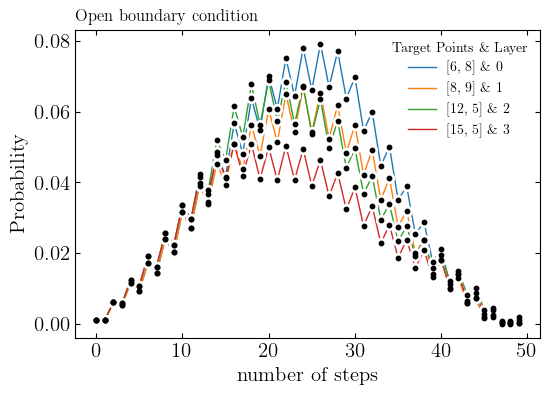

In [42]:
xaxis = np.linspace(0,steps-1,steps)

fig, ax = plt.subplots(figsize = (6,4))

for j in range(layers):
    p = prob[j]
    list__ = list_[j]
    tot_marked = len(list__)
    for i in range(tot_marked):
        ax.scatter(xaxis, p[:,i], color='white', s=50, zorder=2)
        ax.scatter(xaxis, p[:,i], color='black', s=10, zorder=3)
        ax.plot(xaxis,p[:,i], linestyle='-', linewidth=1, zorder=1,label = str(list__[i]) +' \& ' + str(j))

font2 = {'family':'serif','color':'black','size':15}
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='both', labelsize=15)
plt.legend(title = r'Target Points \& Layer',loc='best',frameon = False)
plt.xlabel(r'number of steps',fontdict = font2)
plt.ylabel(r'Probability',fontdict = font2)
plt.title('Open boundary condition',loc='left')
plt.savefig('multi_layer_OBC.pdf',dpi = 500, bbox_inches='tight')
plt.show()

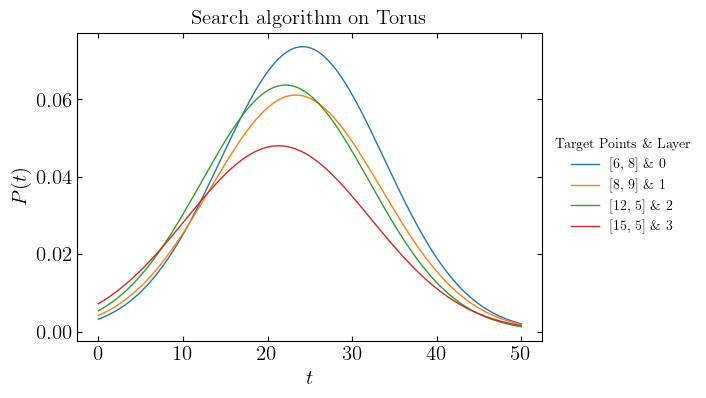

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define the Gaussian function
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-((x - mean) / std_dev)**2 / 2)
mx = []
# Generate sample data
x = np.linspace(0,steps-1,steps)
fig, ax = plt.subplots(figsize = (6,4))

for j in range(layers):
    p = prob[j]
    list__ = list_[j]
    tot_marked = len(list__)
    for i in range(tot_marked):
        x = np.linspace(0,steps-1,steps)
        y = p[:,i]
        initial_guess = [1.0, 0.0, 1.0]  # Initial guess for amplitude, mean, and std_dev
        params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)
        fitted_amplitude, fitted_mean, fitted_std_dev = params
        x = np.linspace(0,steps,4*steps)
        ax.plot(x, gaussian(x, fitted_amplitude, fitted_mean, fitted_std_dev),linestyle='-', linewidth=1, zorder=1,label = str(list__[i]) +' \& ' + str(j))
    mx.append(int(fitted_mean))
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='major', labelsize=15)
font2 = {'family':'serif','color':'black','size':15}
plt.xlabel(r'$t$',fontdict = font2)
plt.ylabel(r'$P(t)$',fontdict = font2)
plt.legend(title = r'Target Points \& Layer',loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)

plt.title('Search algorithm on Torus',fontdict = font2)
fig = 'PLOTS/Search_On_Torus_' + str(np.round(np.random.uniform(),3)) + '.jpg'
# plt.savefig(fig, dpi= 500 , bbox_inches = 'tight')
plt.show()


In [44]:
# Initial State -----

Ψ0 = np.ones((dim,1))
Ψ0 = Ψ0/vec_norm(Ψ0)
coin = np.eye(Qdim)

# Evolution ------

Ψt = np.copy(Ψ0)
steps = 50
P = []

for i in tqdm(range(steps)):
    Pt = np.zeros((N,N,n),dtype = float)
    for kk in range(n):
        zz = np.zeros((n,1))
        zz[kk,0] = 1
        for ii in range(N):
            xx = np.zeros((N,1))
            xx[ii,0] = 1
            for jj in range(N):
                yy = np.zeros((N,1))
                yy[jj,0] = 1
                basis = ft.reduce(np.kron,[xx,yy,zz])
                for cc in range(Qdim):
                    ϕ = np.kron(coin[:,[cc]],basis)
                    Pt[ii,jj,kk] = Pt[ii,jj,kk] + np.absolute(conjT(ϕ)@Ψt)**2
    P.append(Pt)
    Ψt = U@Ψt


100%|██████████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


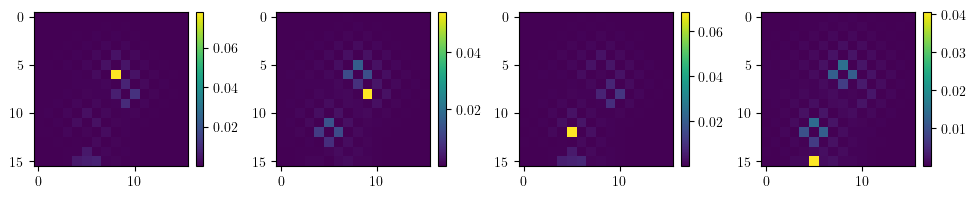

In [45]:
fig, axs = plt.subplots(1, 4,figsize = (12,2))


for i in range(4):
    ax = axs[i]
    pcm = ax.imshow(P[mx[i]][:,:,i])
    fig.colorbar(pcm, ax=ax,fraction=0.046, pad=0.04)
plt.savefig('multi_layer_OBC_MAT.pdf',dpi = 500, bbox_inches='tight')
plt.show()

----------

**3-Torus Search**

-------

In [46]:
N = 2**4 # lattice sites
n = len(list_) # number of layers

TPlus = np.roll(np.eye(N), 1, axis=0)
TMinus = np.roll(np.eye(N), -1, axis=0)
I = np.eye(N)

tplus = np.roll(np.eye(n), 1, axis=0)
tminus = np.roll(np.eye(n), -1, axis=0)
iden = np.eye(n)

In [47]:
def kron_delta(a,b):
    if a == b:
        return 1
    else:
        return 0

def coin_tr(i,j):
    if i == 0 and j == 0:
        return _00
    elif i == 0 and j == 1:
        return _01
    elif i == 1 and j == 0:
        return _10
    else:
        return _11
    
def space_tr(i):
    if i == 0:
        return I
    elif i == 1:
        return TPlus
    else:
        return TMinus

def layer_tr(i):
    if i == 0:
        return iden
    elif i == 1:
        return tplus
    else:
        return tminus



In [48]:
S = np.zeros((dim,dim),dtype = complex)

for i in range(2):
    for j in range(2):
        for k in range(2):
            list1 = [coin_tr(1-i,i),coin_tr(1-j,j),coin_tr(1-k,k)]
            list2 = [space_tr(((-1)**i)*(1-kron_delta(i,j))),space_tr( ((-1)**i)*kron_delta(i,j)),layer_tr((-1)**k)]
            S = S + np.kron(ft.reduce(np.kron,list1),ft.reduce(np.kron,list2))


In [49]:
# Is this unitary? :

print('Is shift operator unitary?' , np.allclose(S@conjT(S),np.eye(dim)))


Is shift operator unitary? True


In [50]:
# Grover's Coin Operator 

Qdim = 2**3
Sdim = N*N*n
dim = Qdim*Sdim

Grover_OP = grover_coin_operator(3) # 2*np.ones((Qdim,Qdim))/Qdim - np.eye(Qdim)

G = np.kron(Grover_OP,np.eye(Sdim))

# Evolution Operator : 

EVOLUTION = S@G


In [51]:
# Oracle -  
Ψc = np.ones((Qdim,1))
Ψc = Ψc/vec_norm(Ψc)

ΨcΨc = Ψc@conjT(Ψc)

mm = np.zeros((Sdim,Sdim))

for i in range(n):
    xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))
    coordinate = list_[i]
    for j in range(len(coordinate)):
        marked_point = coordinate[j]
        xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))
        xx[marked_point[0],0] = 1; yy[marked_point[1],0] = 1; zz[i,0] = 1
        basis = ft.reduce(np.kron,[xx,yy,zz]) # np.kron(xx,yy)
        mm = mm + basis@conjT(basis)

R = np.eye(dim) - 2*np.kron(ΨcΨc,mm) # np.kron((2*np.ones((Qdim,Qdim))/Qdim),mm)


In [120]:
# Total evolution operator :

U = EVOLUTION@R


In [121]:
# Is this unitary? :

print('Is evolution operator unitary?' , np.allclose(U@conjT(U),np.eye(dim)) )


Is evolution operator unitary? True


In [123]:
# Initial State -----

Ψ0 = np.ones((dim,1))
Ψ0 = Ψ0/vec_norm(Ψ0)
coin = np.eye(Qdim)

# Evolution ------

Ψt = np.copy(Ψ0)
steps = 50
prob = [np.zeros((steps,len(list_[i]))) for i in range(n)] # np.zeros((steps,layers))

xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))

for i in range(steps):
    for k in range(n):
        coordinate = list_[k]
        for j in range(len(coordinate)):
            marked_point = coordinate[j]
            xx = np.zeros((N,1)); yy = np.zeros((N,1)); zz = np.zeros((n,1))
            xx[marked_point[0],0] = 1; yy[marked_point[1],0] = 1; zz[k,0] = 1
            basis = ft.reduce(np.kron,[xx,yy,zz])
            for ii in range(Qdim):
                ϕ = np.kron(coin[:,[ii]],basis)
                prob[k][i,j] = prob[k][i,j] + np.absolute(conjT(ϕ)@Ψt)**2
        
    Ψt = U@Ψt


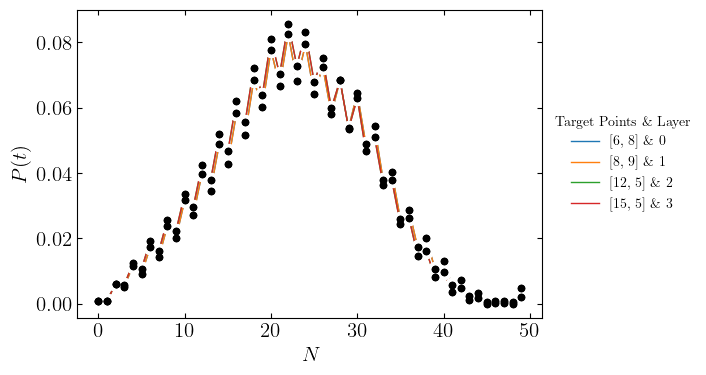

In [124]:
xaxis = np.linspace(0,steps-1,steps)

fig, ax = plt.subplots(figsize = (6,4))

for j in range(layers):
    p = prob[j]
    list__ = list_[j]
    tot_marked = len(list__)
    for i in range(tot_marked):
        ax.scatter(xaxis, p[:,i], color='white', s=100, zorder=2)
        ax.scatter(xaxis, p[:,i], color='black', s=20, zorder=3)
        ax.plot(xaxis,p[:,i], linestyle='-', linewidth=1, zorder=1,label = str(list__[i]) +' \& ' + str(j))

font2 = {'family':'serif','color':'black','size':15}
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='both', labelsize=15)
plt.legend(title = r'Target Points \& Layer',loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)
# plt.xlim(0,20)
plt.xlabel(r'$N$',fontdict = font2)
plt.ylabel(r'$P(t)$',fontdict = font2)
# plt.title('SEARCH ALGORITHM ON TORUS')
fig = 'PLOTS/Search_On_Torus_' + str(np.round(np.random.uniform(),3)) + '.jpg'
# plt.savefig(fig, dpi= 500 , bbox_inches = 'tight')
plt.show()

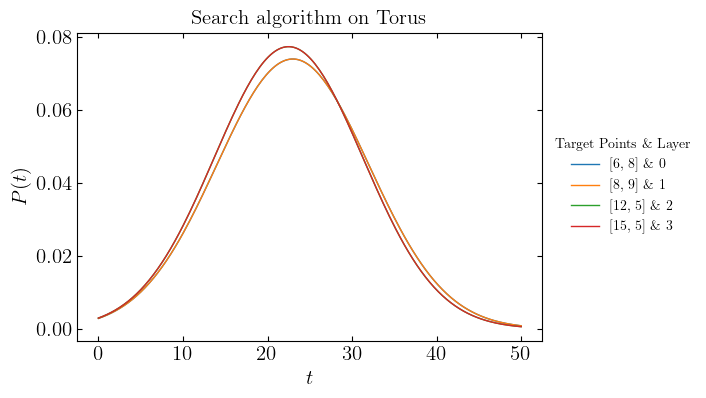

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define the Gaussian function
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-((x - mean) / std_dev)**2 / 2)
mx = []
# Generate sample data
x = np.linspace(0,steps-1,steps)
fig, ax = plt.subplots(figsize = (6,4))

for j in range(layers):
    p = prob[j]
    list__ = list_[j]
    tot_marked = len(list__)
    for i in range(tot_marked):
        x = np.linspace(0,steps-1,steps)
        y = p[:,i]
        initial_guess = [1.0, 0.0, 1.0]  # Initial guess for amplitude, mean, and std_dev
        params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)
        fitted_amplitude, fitted_mean, fitted_std_dev = params
        x = np.linspace(0,steps,4*steps)
        ax.plot(x, gaussian(x, fitted_amplitude, fitted_mean, fitted_std_dev),linestyle='-', linewidth=1, zorder=1,label = str(list__[i]) +' \& ' + str(j))
    mx.append(int(fitted_mean))
plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='major', labelsize=15)
font2 = {'family':'serif','color':'black','size':15}
plt.xlabel(r'$t$',fontdict = font2)
plt.ylabel(r'$P(t)$',fontdict = font2)
plt.legend(title = r'Target Points \& Layer',loc='center left', bbox_to_anchor=(1, 0.5),frameon = False)

plt.title('Search algorithm on Torus',fontdict = font2)
fig = 'PLOTS/Search_On_Torus_' + str(np.round(np.random.uniform(),3)) + '.jpg'
# plt.savefig(fig, dpi= 500 , bbox_inches = 'tight')
plt.show()


In [126]:
# Initial State -----

Ψ0 = np.ones((dim,1))
Ψ0 = Ψ0/vec_norm(Ψ0)
coin = np.eye(Qdim)

# Evolution ------

Ψt = np.copy(Ψ0)
steps = 50
P = []

for i in range(steps):
    Pt = np.zeros((N,N,n),dtype = float)
    for kk in range(n):
        zz = np.zeros((n,1))
        zz[kk,0] = 1
        for ii in range(N):
            xx = np.zeros((N,1))
            xx[ii,0] = 1
            for jj in range(N):
                yy = np.zeros((N,1))
                yy[jj,0] = 1
                basis = ft.reduce(np.kron,[xx,yy,zz])
                for cc in range(Qdim):
                    ϕ = np.kron(coin[:,[cc]],basis)
                    Pt[ii,jj,kk] = Pt[ii,jj,kk] + np.absolute(conjT(ϕ)@Ψt)**2
    P.append(Pt)
    Ψt = U@Ψt


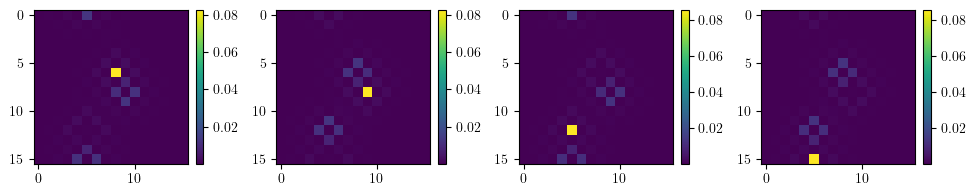

In [127]:
fig, axs = plt.subplots(1, 4,figsize = (12,2))


for i in range(4):
    ax = axs[i]
    pcm = ax.imshow(P[mx[i]][:,:,i])
    fig.colorbar(pcm, ax=ax,fraction=0.046, pad=0.04)

plt.show()